In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np


# Training Loop

In [2]:

def training_gpu(epochs, optimizer, model, loss, t_u_train, t_u_val, t_c_train, t_c_val):

    device = (torch.device('cuda') if torch.cuda.is_available()
              else torch.device('cpu'))

    print("Running on device ", device)
    train_history = []
    test_history = []

    model = model.to(device)
    t_u_train = t_u_train.to(device)
    t_c_train = t_c_train.to(device)
    t_u_val = t_u_val.to(device)
    t_c_val = t_c_val.to(device)

    for epoch in range(epochs):
        t_p_train = model(t_u_train)
        train_loss = loss(t_p_train, t_c_train)

        with torch.no_grad():
            t_p_val = model(t_u_val)
            test_loss = loss(t_p_val, t_c_val)

            train_history.append(train_loss.item())
            test_history.append(test_loss.item())

            if (epoch % 100 == 0):
                print("Epoch = ", epoch, "\t Training Loss: ", train_loss.item(), "\t Test Loss: ", test_loss.item())

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        

    return train_history, test_history

In [3]:
df = pd.read_csv("energy_weather_raw_data.csv")

timestamp = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")

df.drop(columns=["date"], inplace=True)
df.insert(0, "date", timestamp)

In [4]:
# Setup data for training
df.insert(0, "month", df["date"].dt.month)
df.insert(0, "hour", df["date"].dt.hour)
df.insert(0, "day_of_week", df["date"].dt.day_of_week)

df.drop(columns=["date"], inplace=True)
df = pd.get_dummies(df, columns=["main", "description", "hour", "month", "day_of_week"])

df.drop(columns=["current", "voltage", "reactive_power", "apparent_power", "power_factor"], inplace=True)
df

,active_power,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,265.1,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
1,265.1,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
2,265.1,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
3,640.0,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
4,257.6,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605255,316.3,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.99,...,False,False,False,False,False,False,False,True,False,False
605256,1526.3,12.76,11.11,8.07,13.96,1012,39,2.05,160,13.99,...,False,False,False,False,False,False,False,True,False,False
605257,1528.7,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.96,...,False,False,False,False,False,False,False,True,False,False
605258,283.4,12.76,11.11,8.07,13.96,1012,39,2.05,160,13.99,...,False,False,False,False,False,False,False,True,False,False


In [5]:
X = df.drop(columns=["active_power"])
X = X.replace({True, False}, {1, 0}).to_numpy()

t_u = torch.tensor(X, dtype = torch.float32)

Y = df["active_power"].to_numpy()

t_c = torch.tensor(Y,dtype = torch.float32)

n_samples = len(Y)

n_samples
n_features = X.shape[1]
n_features


C:\Users\ecmar\AppData\Local\Temp\ipykernel_20584\3120228677.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({True, False}, {1, 0}).to_numpy()


77

In [6]:
idx = torch.randperm(n_samples)

val_size = int(0.2 * n_samples)
train_size = int(0.8 * n_samples)

train_idx = idx[:train_size]
val_idx = idx[-val_size:]

train_t_u = t_u[train_idx]
val_t_u = t_u[val_idx]

train_t_c = t_c[train_idx].reshape(train_size, 1)
val_t_c = t_c[val_idx].reshape(val_size, 1)

train_t_un = torch.zeros(train_t_u.size())
val_t_un = torch.zeros(val_t_u.size())
# Normalize the features
for i in range(n_features):
    std = torch.std(train_t_u[:, i])
    mean = torch.mean(train_t_u[:, i])

    train_t_un[:,i] = (train_t_u[:, i] - mean) / std

    val_t_un[:, i] = (val_t_u[:, i] - mean) / std



# Comparing Optimizers

Running on device  cuda
Epoch =  0 	 Training Loss:  117753.3203125 	 Test Loss:  117751.1953125
Epoch =  100 	 Training Loss:  27239.1953125 	 Test Loss:  27375.841796875
Epoch =  200 	 Training Loss:  26669.287109375 	 Test Loss:  26828.517578125
Epoch =  300 	 Training Loss:  26313.794921875 	 Test Loss:  26488.681640625
Epoch =  400 	 Training Loss:  26055.3515625 	 Test Loss:  26242.01171875
Epoch =  500 	 Training Loss:  25849.23828125 	 Test Loss:  26044.712890625
Epoch =  600 	 Training Loss:  25671.72265625 	 Test Loss:  25875.22265625
Epoch =  700 	 Training Loss:  25512.845703125 	 Test Loss:  25725.89453125
Epoch =  800 	 Training Loss:  25379.0859375 	 Test Loss:  25601.10546875
Epoch =  900 	 Training Loss:  25412.916015625 	 Test Loss:  25641.494140625


(10000.0, 50000.0)

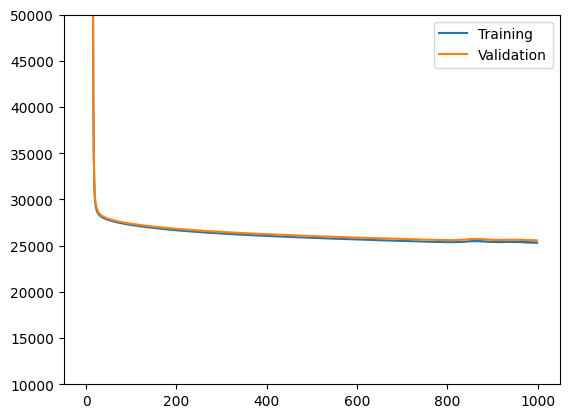

In [7]:
model = nn.Sequential(
    nn.Linear(n_features,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,1)
)
opt = torch.optim.SGD(model.parameters(), lr=1e-4)
n_epochs=1000
train_hist, val_hist = training_gpu(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    t_u_train=train_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()
plt.ylim([10000,50000])

Running on device  cuda
Epoch =  0 	 Training Loss:  117665.40625 	 Test Loss:  117663.3828125
Epoch =  100 	 Training Loss:  26970.71484375 	 Test Loss:  27120.70703125
Epoch =  200 	 Training Loss:  26301.689453125 	 Test Loss:  26478.427734375
Epoch =  300 	 Training Loss:  25929.576171875 	 Test Loss:  26123.6796875
Epoch =  400 	 Training Loss:  25670.865234375 	 Test Loss:  25872.076171875
Epoch =  500 	 Training Loss:  25455.78125 	 Test Loss:  25665.986328125
Epoch =  600 	 Training Loss:  25249.90234375 	 Test Loss:  25470.03515625
Epoch =  700 	 Training Loss:  25044.587890625 	 Test Loss:  25278.78515625
Epoch =  800 	 Training Loss:  24818.86328125 	 Test Loss:  25064.42578125
Epoch =  900 	 Training Loss:  24566.37109375 	 Test Loss:  24827.318359375


(10000.0, 50000.0)

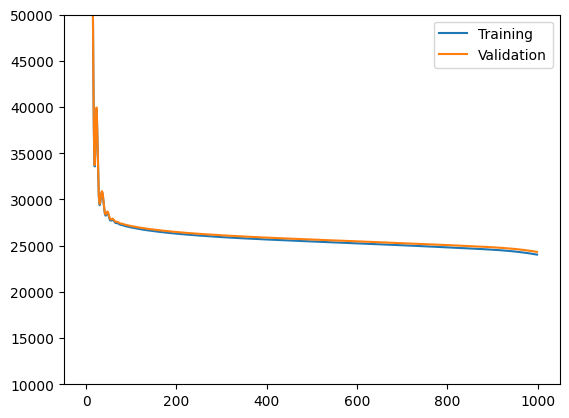

In [8]:
model = nn.Sequential(
    nn.Linear(n_features,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,1)
)
opt = torch.optim.Adam(model.parameters(), lr=5e-3)
n_epochs=1000
train_hist, val_hist = training_gpu(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    t_u_train=train_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()
plt.ylim([10000,50000])

Running on device  cuda
Epoch =  0 	 Training Loss:  117755.1171875 	 Test Loss:  117752.8984375
Epoch =  100 	 Training Loss:  26383.1640625 	 Test Loss:  26561.880859375
Epoch =  200 	 Training Loss:  25771.4609375 	 Test Loss:  25977.42578125
Epoch =  300 	 Training Loss:  25375.658203125 	 Test Loss:  25602.201171875
Epoch =  400 	 Training Loss:  25000.525390625 	 Test Loss:  25243.59375
Epoch =  500 	 Training Loss:  24168.818359375 	 Test Loss:  24468.279296875
Epoch =  600 	 Training Loss:  21843.435546875 	 Test Loss:  22370.69921875
Epoch =  700 	 Training Loss:  19979.208984375 	 Test Loss:  20703.248046875
Epoch =  800 	 Training Loss:  19072.041015625 	 Test Loss:  19914.927734375
Epoch =  900 	 Training Loss:  19522.05859375 	 Test Loss:  20460.87109375
Epoch =  1000 	 Training Loss:  18003.318359375 	 Test Loss:  19011.2734375
Epoch =  1100 	 Training Loss:  18823.423828125 	 Test Loss:  19892.27734375
Epoch =  1200 	 Training Loss:  17460.025390625 	 Test Loss:  18565.1

(10000.0, 50000.0)

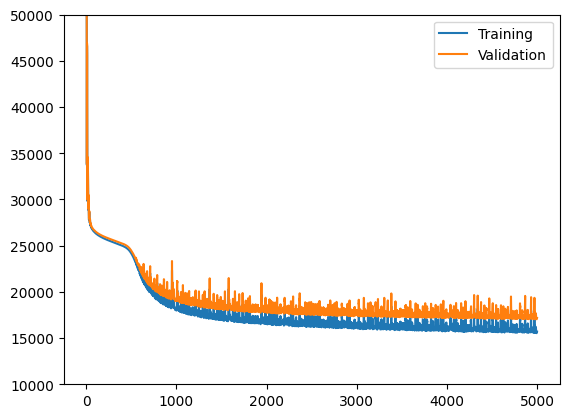

In [9]:
model = nn.Sequential(
    nn.Linear(n_features, 512), 
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,1),
)
opt = torch.optim.Adam(model.parameters(), lr=1e-2) #5e-3 worked with Adam
n_epochs=5001
train_hist, val_hist = training_gpu(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    t_u_train=train_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()
plt.ylim([10000,50000])

In [10]:
import numpy as np
idx = np.argmin(val_hist)

print("Training:\t", train_hist[idx])
print("Validation:\t", val_hist[idx])

Training:	 15533.931640625
Validation:	 17036.435546875


Running on device  cuda
Epoch =  0 	 Training Loss:  117738.5390625 	 Test Loss:  117802.65625
Epoch =  100 	 Training Loss:  25989.115234375 	 Test Loss:  26101.783203125
Epoch =  200 	 Training Loss:  26442.623046875 	 Test Loss:  26569.208984375
Epoch =  300 	 Training Loss:  24782.486328125 	 Test Loss:  24954.189453125
Epoch =  400 	 Training Loss:  22788.328125 	 Test Loss:  23132.5859375
Epoch =  500 	 Training Loss:  23050.474609375 	 Test Loss:  23459.490234375
Epoch =  600 	 Training Loss:  19751.7421875 	 Test Loss:  20426.2734375
Epoch =  700 	 Training Loss:  19877.990234375 	 Test Loss:  20498.736328125
Epoch =  800 	 Training Loss:  19286.474609375 	 Test Loss:  19918.9296875
Epoch =  900 	 Training Loss:  23305.3359375 	 Test Loss:  23747.96875
Epoch =  1000 	 Training Loss:  18596.35546875 	 Test Loss:  19540.681640625
Epoch =  1100 	 Training Loss:  17514.017578125 	 Test Loss:  18443.52734375
Epoch =  1200 	 Training Loss:  17468.171875 	 Test Loss:  18420.412109375


(10000.0, 50000.0)

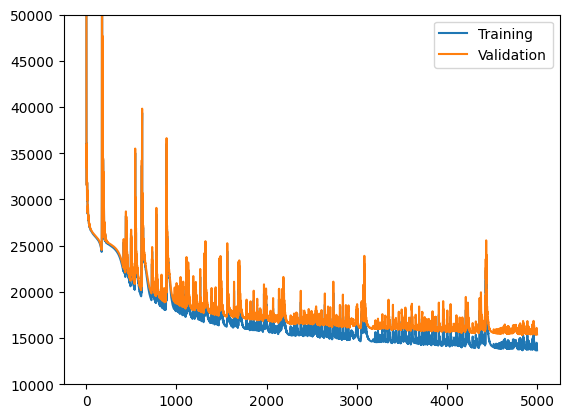

In [ ]:
model = nn.Sequential(
    nn.Linear(n_features, 512), 
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.ReLU(),
    nn.Linear(64,1)
)
opt = torch.optim.Adam(model.parameters(), lr=5e-3)
n_epochs=5001
train_hist, val_hist = training_gpu(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    t_u_train=train_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()
plt.ylim([10000,50000])

In [10]:
print(min(val_hist))

15346.0390625


Running on device  cuda
Epoch =  0 	 Training Loss:  117440.96875 	 Test Loss:  119148.96875
Epoch =  100 	 Training Loss:  85611.3203125 	 Test Loss:  87174.5
Epoch =  200 	 Training Loss:  66102.859375 	 Test Loss:  67547.609375
Epoch =  300 	 Training Loss:  54445.3515625 	 Test Loss:  55792.58984375
Epoch =  400 	 Training Loss:  48061.10546875 	 Test Loss:  49331.50390625
Epoch =  500 	 Training Loss:  44903.484375 	 Test Loss:  46116.453125
Epoch =  600 	 Training Loss:  43506.4609375 	 Test Loss:  44679.02734375
Epoch =  700 	 Training Loss:  42955.08203125 	 Test Loss:  44100.98828125
Epoch =  800 	 Training Loss:  42758.44921875 	 Test Loss:  43887.875
Epoch =  900 	 Training Loss:  42691.1015625 	 Test Loss:  43810.98828125
Epoch =  1000 	 Training Loss:  42664.328125 	 Test Loss:  43779.0234375
Epoch =  1100 	 Training Loss:  42844.94140625 	 Test Loss:  44067.83984375
Epoch =  1200 	 Training Loss:  41003.58984375 	 Test Loss:  42227.640625
Epoch =  1300 	 Training Loss:  4

(10000.0, 50000.0)

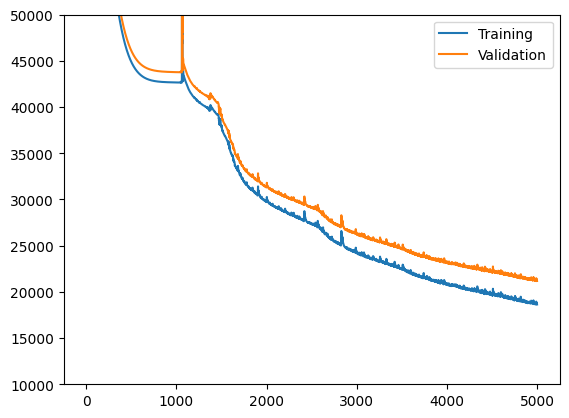

In [8]:
# Trying with a tanh activation function
model = nn.Sequential(
    nn.Linear(n_features, 512), 
    nn.Tanh(),
    nn.Linear(512, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256,64),
    nn.Tanh(),
    nn.Linear(64,1)
)
opt = torch.optim.Adam(model.parameters(), lr=1e-2) #5e-3 worked with Adam
n_epochs=5001
train_hist, val_hist = training_gpu(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    t_u_train=train_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()
plt.ylim([10000,50000])

In [10]:
import numpy as np
idx = np.argmin(val_hist)

print("Training:\t", train_hist[idx])
print("Validation:\t", val_hist[idx])

Training:	 18639.240234375
Validation:	 21182.361328125


# Using batches

In [7]:
def training_batch(epochs, optimizer, model, loss, loader, t_u_val, t_c_val):

    device = (torch.device('cuda') if torch.cuda.is_available()
              else torch.device('cpu'))
    
    print("Running on device ", device)
    train_history = []
    test_history = []

    model = model.to(device)

    t_u_val = t_u_val.to(device)
    t_c_val = t_c_val.to(device)

    for epoch in range(epochs):
        for t_u_train, t_c_train in loader:

            t_u_train = t_u_train.to(device)
            t_c_train = t_c_train.to(device)

            t_p_train = model(t_u_train)
            train_loss = loss(t_p_train, t_c_train)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        with torch.no_grad():
            t_p_val = model(t_u_val)
            test_loss = loss(t_p_val, t_c_val)

            train_history.append(train_loss.item())
            test_history.append(test_loss.item())

            if (epoch % 10 == 0):
                print("Epoch = ", epoch, "\t Training Loss: ", train_loss.item(), "\t Test Loss: ", test_loss.item())
    

    return train_history, test_history

Running on device  cuda
Epoch =  0 	 Training Loss:  28750.826171875 	 Test Loss:  26647.666015625
Epoch =  10 	 Training Loss:  18304.642578125 	 Test Loss:  18961.6640625
Epoch =  20 	 Training Loss:  17409.39453125 	 Test Loss:  17841.03125
Epoch =  30 	 Training Loss:  19682.037109375 	 Test Loss:  17161.419921875
Epoch =  40 	 Training Loss:  17869.17578125 	 Test Loss:  16724.73046875
Epoch =  50 	 Training Loss:  14690.4326171875 	 Test Loss:  16609.583984375
Epoch =  60 	 Training Loss:  14152.9677734375 	 Test Loss:  16513.36328125
Epoch =  70 	 Training Loss:  9721.3212890625 	 Test Loss:  16153.9736328125
Epoch =  80 	 Training Loss:  14020.80859375 	 Test Loss:  16202.251953125
Epoch =  90 	 Training Loss:  12514.1494140625 	 Test Loss:  16049.27734375
Epoch =  100 	 Training Loss:  15659.5810546875 	 Test Loss:  15931.5830078125
Epoch =  110 	 Training Loss:  18368.337890625 	 Test Loss:  15860.9130859375
Epoch =  120 	 Training Loss:  15518.1748046875 	 Test Loss:  15945.

(10000.0, 50000.0)

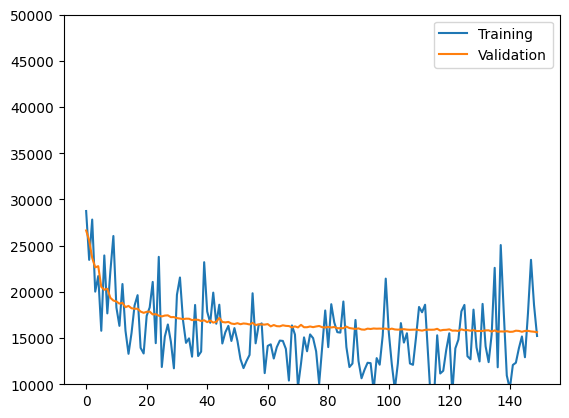

In [ ]:
# Custom dataset to put into the batch loader.
class data(Dataset):
    def __init__(self):
        self.x = train_t_un
        self.y = train_t_c

    def __len__(self):
        return self.y.size(dim=0)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_data = data()
loader = DataLoader(train_data, batch_size=1024, shuffle=True)

model = nn.Sequential(
    nn.Linear(n_features, 512), 
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,64),
    nn.ReLU(),
    nn.Linear(64,1)
)
opt = torch.optim.Adam(model.parameters(), lr=.005)
n_epochs=150
train_hist, val_hist = training_batch(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    loader=loader,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()
plt.ylim([10000,50000])

In [27]:
import numpy as np
idx = np.argmin(val_hist)

print("Training:\t", train_hist[idx])
print("Validation:\t", val_hist[idx])

Training:	 15227.197265625
Validation:	 15632.7607421875


Running on device  cuda
Epoch =  0 	 Training Loss:  26572.40625 	 Test Loss:  26171.2734375
Epoch =  10 	 Training Loss:  16767.5703125 	 Test Loss:  18025.287109375
Epoch =  20 	 Training Loss:  14227.845703125 	 Test Loss:  16701.556640625
Epoch =  30 	 Training Loss:  10190.8310546875 	 Test Loss:  16420.888671875
Epoch =  40 	 Training Loss:  16044.681640625 	 Test Loss:  16027.4609375
Epoch =  50 	 Training Loss:  15503.7021484375 	 Test Loss:  16286.109375
Epoch =  60 	 Training Loss:  9007.7880859375 	 Test Loss:  15658.494140625
Epoch =  70 	 Training Loss:  16160.90625 	 Test Loss:  15411.3876953125
Epoch =  80 	 Training Loss:  17959.3125 	 Test Loss:  15256.232421875
Epoch =  90 	 Training Loss:  14607.2548828125 	 Test Loss:  15507.6982421875
Epoch =  100 	 Training Loss:  10975.7880859375 	 Test Loss:  15068.6015625
Epoch =  110 	 Training Loss:  12203.98828125 	 Test Loss:  15072.0400390625
Epoch =  120 	 Training Loss:  14189.484375 	 Test Loss:  14843.8857421875
Epoch 

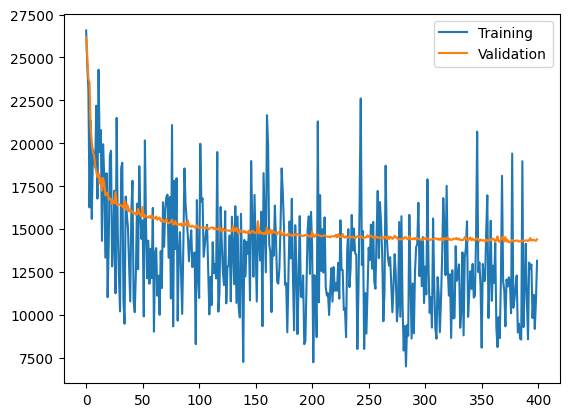

In [9]:
# Custom dataset to put into the batch loader.
class data(Dataset):
    def __init__(self):
        self.x = train_t_un
        self.y = train_t_c

    def __len__(self):
        return self.y.size(dim=0)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_data = data()
loader = DataLoader(train_data, batch_size=2048, shuffle=True)

model = nn.Sequential(
    nn.Linear(n_features, 512), 
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,1)
)
opt = torch.optim.Adam(model.parameters(), lr=.005)
n_epochs=400
train_hist, val_hist = training_batch(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    loader=loader,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()


idx = np.argmin(val_hist)

print("Training:\t", np.sqrt(train_hist[idx]))
print("Validation:\t", np.sqrt(val_hist[idx]))